In [1]:
%matplotlib widget
import sys
import os 
import pickle

from ece4078.localization.dynamic_system_import import import_based_on_version
import_based_on_version(globals(), locals())
from ece4078.localization.Renderer import *

sys.path.insert(0, os.path.abspath('Practical03_Support'))
from Measurements import *

with open('Practical03_Support/data/data_ekf.dat', "rb") as f:
    data = pickle.load(f)

# Setup our robot
bot = PenguinPi(0.14, 0.01)
gt_state = data['state']
control_replay = data['control']
measurements_replay = data['measurement']
# Here are our true marker positions
markers = data['markers']

# Set the initial state of the robot from the data
init_x, init_y, init_theta = gt_state[0,:]
bot.set_state(x=init_x, y=init_y, theta=init_theta)

#----------------------------------PARAMETERS--------------------------------------
# Initial incertainty of our robot
P = np.eye(3)*100
# Uncertainty in our left and right wheel motors
sigma_drive = np.array([10,10])
# Uncertainty in measurement
sigma_measure = np.eye(2)*100
#-----------------------------------------------------------------------------------

# Apply our control to the robot and visualize
# Our timestamp is always 0.2
dt = 0.2
# Here we will save our state variable 
state = np.zeros((control_replay.shape[0],3))
# Here we save the robot covariances
robot_cov = np.zeros(((control_replay.shape[0],3,3)))
def predict_step(bot, prev_P, drive_signal):
     # 1. Predict state
    bot.drive(drive_signal)
    x_bar = np.array(bot.get_state()).reshape((3,1))
    # 2.. Linearize about prediction
    A = bot.derivative_drive(drive_signal)
    # 3. Get covariance
    Q = bot.covariance_drive(drive_signal)
    # 4. Predict covariance
    
    #TODO: Complete this step -----------------------------------------------------
    P = A @ prev_P @ A.T + Q
    #ENDTODO ----------------------------------------------------------------------

    return P, x_bar
def construct_R(measurements):
    # Stack measurements and set covariance
    z = np.concatenate([lm.position.reshape(-1,1) for lm in measurements], axis=0)
    
    #TODO: Complete this step -----------------------------------------------------
    R = np.zeros((2*len(measurements),2*len(measurements)))
    for i in range(len(measurements)):
        R[2*i:2*i+2,2*i:2*i+2] = measurements[i].covariance
    #ENDTODO ----------------------------------------------------------------------

    return z, R
def update_step(bot, P, R, z, x_bar, tags):
    # 1. Get location of measurements given robot's current state
    z_hat = bot.measure(markers, tags)
    z_hat = z_hat.reshape((-1,1),order="F")
    # 2. Linearize measurement about robot's current state
    C = bot.derivative_measure(markers, tags)
    
    #TODO: Complete this step -----------------------------------------------------
    # 3. Compute Kalman Gain
    S = C @ P @ C.T + R
    K = P @ C.T @ np.linalg.inv(S)
    # 4. Correct state
    y = z - z_hat
    corrected_x = x_bar + K @ y
    # 5. Correct covariance
    corrected_P = (np.eye(corrected_x.shape[0]) - K @ C) @ P
    #ENDTODO ----------------------------------------------------------------------
    
    return corrected_x, corrected_P
for c in range(control_replay.shape[0]):
    # Set the measurement covariances
    for mes in measurements_replay[c]:
        mes.covariance = sigma_measure 
    
    drive_signal = DriveMeasurement(control_replay[c,0],control_replay[c,1],dt,sigma_drive[0],sigma_drive[1])
    tags = [lm.tag for lm in measurements_replay[c]]
    
    #TODO: Complete this step -----------------------------------------------------
    # Prediction Step 
    P, x_bar = predict_step(bot, P, drive_signal)
    # Construct measurement index list
    z, R = construct_R(measurements_replay[c])
    # Update step
    x, P = update_step(bot, P, R, z, x_bar, tags)
    #ENDTODO ----------------------------------------------------------------------
    
    # Set the estimated as next state.
    bot.set_state(x[0], x[1], x[2])
    state[c,:] = np.array(bot.get_state()).flatten()
    # Drive and predict
    robot_cov[c,:,:] = P[0:3,0:3]
    
#Create a visualizer and visualize our state
# rend = Renderer.Instance()
# rend.initialize(state,measurements_replay, true_state = gt_state,robot_cov=robot_cov, add_aruco=True)

In [56]:
gt_state.shape

(300, 3)

In [6]:
robot_cov.shape

(300, 3, 3)

In [70]:
mes_replay = []
for mes in measurements_replay:
    tmp_dict = {}
    for m in mes:
        tmp_dict.update({m.tag:  m.position.squeeze().tolist()})
    mes_replay.append(tmp_dict)

mes_replay[0]

{0: [0.18175121298239988, 1.0656390057010976],
 1: [-0.29288737893589534, -0.16616003598174492],
 2: [-0.5890536307327968, 0.8108988895715797],
 3: [-0.31734633787406613, 0.9836810589734423],
 4: [-0.5858681065074361, 0.09822864072506823],
 5: [0.5417598822365768, 0.612650398271599],
 6: [0.4725170191390689, 0.7959483201648674],
 7: [-0.840317293463913, 0.43321410150074025],
 8: [0.3018543705884844, -0.20091771192556523],
 9: [0.5864257266630583, 0.1986648116684377]}

In [118]:
import dash, numpy as np, plotly.graph_objects as go
from dash import dcc, html, Input, Output, State
from pathlib import Path
import base64

fig = go.Figure(go.Scatter(x=gt_state[:, 0], y=gt_state[:, 1], mode="lines", line=dict(width=2, color="red")))

fig.add_annotation(
    x=-2,  y=-2,  xref="x", yref="y",      # arrow head
    ax=-2, ay=-2, axref="x", ayref="y",    # arrow tail
    text="Left block",                   # any label
    showarrow=True,
    arrowhead=3,
    xanchor="right",  # text sits to the *left* of ax
    yanchor="middle"  # keep vertical centre aligned
)

N = state.shape[0]
imgs_folder_path   = Path("images")
marker_files       = sorted(p for p in imgs_folder_path.iterdir() if p.name.startswith("M"))
marker_world_width = 0.3  # world-units
for ii, path in enumerate(marker_files):
    parts = path.stem.split('_')
    mp    = np.array([float(parts[1]), float(parts[2])])
    encoded = base64.b64encode(path.read_bytes()).decode()

    fig.add_layout_image(
        dict(
            source=f"data:image/png;base64,{encoded}",
            x=mp[0] - marker_world_width / 2,
            y=mp[1] + marker_world_width / 2,
            sizex=marker_world_width,
            sizey=marker_world_width,
            xref="x", yref="y"
        )
    )

    fig.add_annotation(
        x=mp[0], y=mp[1],
        text=f"<b>{ii}</b>",
        showarrow=False,
        font=dict(color="red", size=14)
    )
fig.update_layout(
    plot_bgcolor="white",
    margin=dict(l=0, r=0, t=20, b=0),
    xaxis=dict(range=[-4, -1.5], title="x", showline=True, linecolor="black", mirror=True),
    yaxis=dict(range=[-3.5,-1.5], title="y", showline=True, linecolor="black", mirror=True, scaleratio = 1, scaleanchor = "x"),
    showlegend=False,
    autosize=False
)

app = dash.Dash(__name__)
app.layout = html.Div(
    [
        # dcc.Slider(id="t-slider", min=0, max=N, step=1, value=0),
        html.Div(
            dcc.Slider(id="t-slider", min=0, max=N-1, step=1, value=0, marks = None,
                       tooltip={"placement": "bottom", "always_visible": True}), 
            style={"flex": "1 1 50px", "minWidth": "50px", "maxWidth": "500px"}
        ),
        dcc.Store(id="data-store", data= {"x": state[:, 0].tolist(), 
                                     "y": state[:, 1].tolist(), 
                                     "theta":state[:, 2].tolist(),
                                     "cov": robot_cov[:, :2, :2].tolist()}),
        dcc.Graph(id="graph", figure=fig),
    ]
)

app.clientside_callback(
    """
    function(t, data, fig){
        if(!data) { return fig; }

        /* ----- unpack current covariance & state ----- */
        const cov   = data.cov[t];        // 3×3
        const xc = data.x[t], yc = data.y[t];

        /* ----- 2×2 covariance of x–y only ----- */
        const a = cov[0][0],
              b = cov[0][1],
              c = cov[1][0],
              d = cov[1][1];

        /* eigenvalues (lam1 >= lam2) of [[a,b],[c,d]] */
        const B = -(a + d);
        const C = a*d - b*c;
        const disc = Math.sqrt(B*B - 4*C);
        const lam1 = (-B + disc) / 2;
        const lam2 = (-B - disc) / 2;

        /* eigenvector for lam1 → orientation ϕ */
        const v1x = lam1 - d,
              v1y = c;
        const vnorm = Math.hypot(v1x, v1y);
        const phi   = Math.acos(v1x / vnorm);   // rad

        /* optional: scale kσ (here k = 1) */
        const s1 = lam1/2,
              s2 = lam2/2;

        /* ----- build SVG path for the ellipse ----- */
        const n = 30;
        let path = "";
        for(let i = 0; i <= n; i++){
            const tparam = 2*Math.PI*i/n;
            const dx =  s1*Math.cos(tparam);
            const dy =  s2*Math.sin(tparam);
            const x  = xc + dx*Math.cos(phi) - dy*Math.sin(phi);
            const y  = yc + dx*Math.sin(phi) + dy*Math.cos(phi);
            path += (i === 0 ? "M" : "L") + x + "," + y;
        }
        path += " Z";

        /* ----- clone fig & inject shape ----- */
        const newFig = {...fig, layout: {...fig.layout}};
        newFig.layout.shapes = [{
            type: "path",
            path: path,
            xref: "x", yref: "y",
            line: {color: "blue", width: 2}
        }];
        newFig.data[1] = {
            x: data.x.slice(0, t+1),
            y: data.y.slice(0, t+1),
            mode: "lines",
            line: {color:"blue"},
            name: "trajectory"
        };

        let annotations = [...(newFig.layout.annotations || [])];
        annotations[0] = {
            ...annotations[0],
            x: data.x[t],           // arrow head at current state
            y: data.y[t]
        };
        newFig.layout.annotations = annotations;
        
        return newFig;
    }
    """,
    Output("graph", "figure"),
    Input("t-slider", "value"),
    State("data-store", "data"),
    State("graph", "figure")
)

app.run(port=8080, host = "0.0.0.0")

In [3]:
from Practical03_Support.plotly_Renderer import plotly_Renderer

a = plotly_Renderer(state, true_state = gt_state, 
                    measurements = measurements_replay, add_aruco = True,
                    robot_cov = robot_cov)
a.get_IFrame()
# a = plotly_Renderer(state, true_state = gt_state)
# a.get_IFrame()

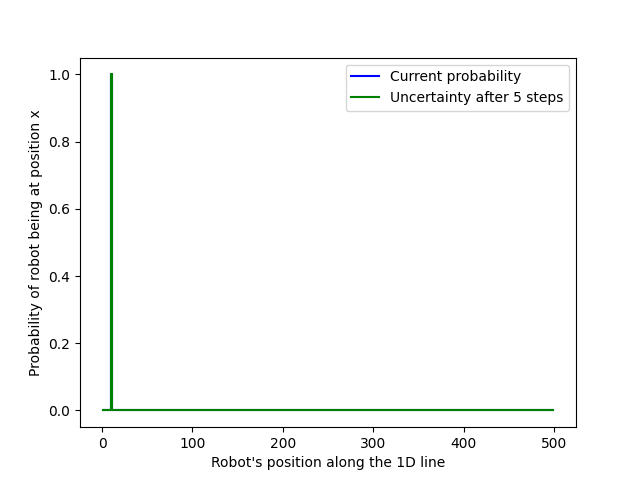

In [20]:
from Helper import *
from SLAM_plotting import *
from Distribution import *

# We start with a known position: probability 1.0 at position 10
plt.ion()
belief_position = Distribution.unit_pulse(10)
x, y = belief_position.plotlists(0, 500)
old_line,line = createInitialPlot(x, y)

def convolve_distribution(b=None):
    global belief_position
    
    # For each new control:
    # - there is 50% chance the robot moves 1m
    # - there is 25% chance the robot moves 1.1m
    # - there is 25% change the robot moves 0.9m
    
    # Plot prior belief
    old_x, old_y = belief_position.plotlists(0, 500)
    old_line.set_data(old_x, old_y)
    
    # We enconde this belief into a new distribution
    for i in range(5):
        move_distribution = Distribution.triangle(1,2)
        # We modify our belief about the robots position with a convolution
        belief_position = belief_position.convolve(move_distribution)
        new_x, new_y = belief_position.plotlists(0, 500)
        line.set_data(new_x, new_y)
        
def reset(b=None):
    global belief_position
    belief_position = Distribution.unit_pulse(10)
    x, y = belief_position.plotlists(0, 500)
    old_line.set_data(x,y)
    line.set_data(x, y)
    
btn_move, btn_reset = createbtns()
btn_move.on_click(convolve_distribution)
btn_reset.on_click(reset)

In [2]:
from ece4078.plotly_viz import * 
app = InteractiveApp(port=8082)
app.run()

Dash app running on http://0.0.0.0:8082/


In [3]:
from IPython.display import IFrame
from Practical03_Support.plotly_SLAM_plotting import *
from Practical03_Support.Distribution import *

initial_belief = Distribution.unit_pulse(10)

def callback_fn(action, belief):
    if action == "reset":
        return initial_belief
    else:
        for _ in range(5):
            move_dist = Distribution.triangle(1, 2)
            belief = belief.convolve(move_dist)
        return belief

app.register_demo("SLAM_plotting", SLAM_plotting)

app.use_demo("SLAM_plotting", callback_fn = callback_fn, init_belief = initial_belief)
IFrame(app.display_url, height = 500, width = "100%")

In [4]:
from Practical03_Support.Helper import *

# 1D model parameters
u = 100 # We will drive our robot with a constant control input
a = 1
b = 1

# Number of measurements we want to generate
steps = 10

# This is our measurement constant
C = 1

#This is our true noise
true_move_noise = 2
true_mes_noise = 10

true_state, measurements = generate_measurements(steps=steps, a=a, b=b, u=u, c=C, true_move_noise=true_move_noise,
                                                true_mes_noise=true_mes_noise)

#----------------------------------PARAMETERS--------------------------------------
# This is our mean at t, we initialize at zero
mu_k = 0
# This is our covariance at t, we initialize very small implying we know x0 very well
sigma_k = 0.4
# This is the uncertainty in our move function 
sigma_Q = 2
# This is what we think our measurement noise is
sigma_R = 10
#-----------------------------------------------------------------------------------

# We will save our predicted state here
pred_state = np.zeros((steps,1)) 
# We will save our estimated state here
est_state = np.zeros((steps,1))

# Plotting code
x = np.linspace(0,1000,2000)


def step_fn(k, mu_k, sigma_k):

    # Prediction
    mu_bar    = a * mu_k + b*u
    sigma_bar = np.sqrt(a*a*sigma_k*sigma_k + sigma_Q*sigma_Q)

    # Update step
    z = measurements[k+1]
    #TODO: Complete this step -----------------------------------------------------
    K = C*sigma_bar*sigma_bar/(C*C*sigma_bar*sigma_bar + sigma_R*sigma_R)
    mu_next = mu_bar + K*(z-C*mu_bar)
    sigma_next = (1-K*C)*sigma_bar
    #ENDTODO ----------------------------------------------------------------------

    # Plot state distribution based on model prediction (this is our prior)
    y_pred = norm.pdf(x, loc=mu_bar, scale=sigma_bar)

    # Here we compute the likelihood of the robot's position given a new measurement 
    # Note we plot the measurement centered around the true measured value
    y_mes = norm.pdf(x, loc=measurements[k+1], scale=sigma_R)

    # We combine the knowledge from our model and the likelihood given our noisy measurement
    y_est = norm.pdf(x, loc=mu_next, scale=sigma_next)

    return mu_next, sigma_next, y_pred, y_mes, y_est

app.register_demo("KF_plotting", KF_plotting)
app.use_demo("KF_plotting", step_fn = step_fn, x = x, mu_k = mu_k, sigma_k = sigma_k, true_state = true_state.flatten(), sigma_R = sigma_R)
IFrame(app.display_url, height = 500, width = "100%")

In [11]:
import dash, json, base64
import plotly.graph_objects as go
from dash import dcc, html, Input, Output, State
from pathlib import Path
import numpy as np

fig = go.Figure(
    layout=dict(
        plot_bgcolor="white",
        margin=dict(l=0, r=0, t=20, b=0),
        xaxis=dict(range=[-4, -1.5], title="x",
                   showline=True, linecolor="black", mirror=True),
        yaxis=dict(range=[-3.5, -1.5], title="y",
                   showline=True, linecolor="black", mirror=True,
                   scaleratio=1, scaleanchor="x"),
        showlegend=False,
        autosize=False,
        uirevision="const"
    )
)

for p in sorted(Path("images").glob("M*.png")):
    x, y = map(float, p.stem.split('_')[1:3])
    fig.add_layout_image(
        dict(
            source="data:image/png;base64," +
                   base64.b64encode(p.read_bytes()).decode(),
            x=x-0.15, y=y+0.15, sizex=0.3, sizey=0.3,
            xref="x", yref="y"
        )
    )

fig.add_annotation(
    x=-2, y=-2, ax=-2, ay=-2,
    text="Left block",
    xref="x", yref="y", axref="x", ayref="y",
    arrowhead=3, xanchor="right", yanchor="middle"
)

STATIC_JSON = fig.to_plotly_json()        # ← one dict with layout *and* images

# ----------------------------------------------------------------------
# 3.  DASH APP  ---------------------------------------------------------
# ----------------------------------------------------------------------
app = dash.Dash(__name__)

app.layout = html.Div(
    [
        dcc.Store(id="static-fig", data=STATIC_JSON, storage_type="memory"),
        dcc.Store(
            id="data-store",
            data=dict(
                x=state[:, 0].tolist(),
                y=state[:, 1].tolist(),
                cov=robot_cov[:, :2, :2].tolist(),
            ),
        ),
        dcc.Slider(
            id="t-slider", min=0, max=N-1, step=1, value=0,
            marks=None, tooltip={"placement": "bottom", "always_visible": True}
        ),
        dcc.Graph(id="graph", figure=STATIC_JSON),
    ]
)

# ----------------------------------------------------------------------
# 4.  CLIENT-SIDE CALLBACK  --------------------------------------------
# ----------------------------------------------------------------------
app.clientside_callback(
    """
    function(t, data, stat){
        if(!stat || !data){ return window.dash_clientside.no_update; }

        /* ---------- build dynamic trace ---------- */
        const trace = {
            x: data.x.slice(0, t+1),
            y: data.y.slice(0, t+1),
            mode: "lines",
            line: {color: "blue"},
            name: "trajectory"
        };

        /* ---------- covariance ellipse ---------- */
        const cov = data.cov[t];
        const a=cov[0][0], b=cov[0][1], c=cov[1][0], d=cov[1][1];
        const B=-(a+d), C=a*d-b*c, D=Math.sqrt(B*B-4*C);
        const l1=(-B+D)/2, l2=(-B-D)/2;
        const vx=l1-d, vy=c, phi=Math.atan2(vy,vx);
        const s1=l1/2,  s2=l2/2, n=30;
        const xc=data.x[t], yc=data.y[t];
        let path="";
        for(let i=0;i<=n;i++){
            const th=2*Math.PI*i/n,
                  dx=s1*Math.cos(th), dy=s2*Math.sin(th),
                  x=xc+dx*Math.cos(phi)-dy*Math.sin(phi),
                  y=yc+dx*Math.sin(phi)+dy*Math.cos(phi);
            path+=(i?"L":"M")+x+","+y;
        }
        path+=" Z";

        const shape = {
            type:"path", path:path, xref:"x", yref:"y",
            line:{color:"blue",width:2}
        };

        const ann = {...stat.layout.annotations[0],
                     x:xc, y:yc, ax:xc, ay:yc};

        /* ---------- merge static + dynamic ---------- */
        return {
            ...stat,                     // background, axes, images
            data:[trace],
            layout:{
                ...stat.layout,
                shapes:[shape],
                annotations:[ann]
            }
        };
    }
    """,
    Output("graph", "figure"),
    Input("t-slider", "value"),
    State("data-store",  "data"),
    State("static-fig",  "data"),
)

app.run(host="0.0.0.0", port=8080)